In [406]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

import pprint

In [407]:
df = pd.read_csv("..\OMLT_ML\data\polynomial3.csv")
df.head()

,theta,z,u
0,-20.0,-6.08,-3.92
1,-19.5,-5.58,-4.42
2,-19.1,-5.13,-4.87
3,-18.6,-4.71,-5.29
4,-18.1,-4.32,-5.68


In [408]:
X = df["theta"]
y = df["z"]

# X = X.reset_index(drop = True)
# y = y.reset_index(drop = True)

X = X.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)

X.shape, y.shape

((180, 1), (180, 1))

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data_linear = lgb.Dataset(X_train, label=y_train)

train_data_normal = lgb.Dataset(X_train, label=y_train)

In [410]:
params = {
    "objective": "regression",
    "metric": "rmse",
    # "max_depth": 10,
    # "num_leaves": 50,
    "learning_rate": 1,
    "verbosity": 2,
    'linear_tree': True,
    'num_iterations': 10,
}

model_linear = lgb.train(params, train_data_linear)
# model_normal = lgb.train(params, train_data_normal)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000012 seconds, init for row-wise cost 0.001107 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 1
[LightGBM] [Info] Start training from score 3.375086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\shumengl\.conda\envs\omlt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\shumengl\.conda\envs\omlt\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [411]:
y_pred_linear = model_linear.predict(X_test)
# y_pred_normal = model_normal.predict(X_test)

In [412]:
print(f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
# print(f"Normal trees error: {round(mean_squared_error(y_test, y_pred_normal),3)}")

Linear trees error: 0.379


In [413]:
y_linear = model_linear.predict(X)
# y_normal = model_normal.predict(X)

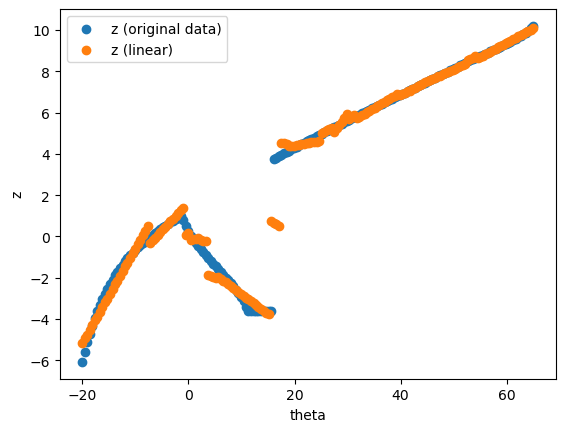

In [414]:
# plotting results
plt.scatter(X, y, label = 'z (original data)')
plt.scatter(X, y_linear, label = 'z (linear)')
# plt.scatter(X, y_normal, label = 'z (normal)')
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

In [415]:
print(model_linear.params)

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 1, 'verbosity': 2, 'linear_tree': True, 'num_iterations': 10, 'early_stopping_round': None}


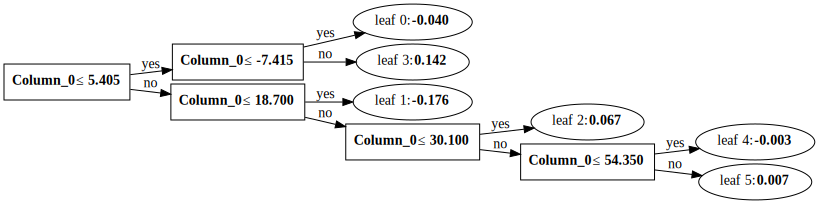

In [416]:
# extra step to allow graphviz to be found 
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# lgb.plot_tree(model_linear)
# for i in range(params['num_iterations']):
p = lgb.create_tree_digraph(model_linear, params['num_iterations']-1)
p

In [417]:
# model_linear.trees_to_dataframe()

In [418]:
model_linear.save_model('model.txt')